# Veri Hikayesi

In [1]:
# Gerekli kütüphaneleri import et
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Excel dosyasını yükle
file_path = '../data/elektrik_veri_hashed.xlsx'
xls = pd.ExcelFile(file_path)

# Sayfa isimlerini görüntüle
print("Sayfa isimleri:", xls.sheet_names)

# Her sayfayı ayrı DataFrame'e yükle
df_tahsilat = pd.read_excel(xls, sheet_name='Tahsilat')
df_tahsilat_1 = pd.read_excel(xls, sheet_name='Tahsilat 1')
df_tahakkuk = pd.read_excel(xls, sheet_name='Tahakkuk')      # Hamamözü
df_tahakkuk_1 = pd.read_excel(xls, sheet_name='Tahakkuk 1')  # Gümüşhacıköy
df_tahakkuk_2 = pd.read_excel(xls, sheet_name='Tahakkuk 2')  # Göynücek

# DataFrame boyutlarını kontrol et
print(f"Tahsilat: {df_tahsilat.shape}")
print(f"Tahsilat 1: {df_tahsilat_1.shape}")
print(f"Tahakkuk (Hamamözü): {df_tahakkuk.shape}")
print(f"Tahakkuk 1 (Gümüşhacıköy): {df_tahakkuk_1.shape}")
print(f"Tahakkuk 2 (Göynücek): {df_tahakkuk_2.shape}")

df_tuketim = pd.concat([df_tahakkuk, df_tahakkuk_1, df_tahakkuk_2], ignore_index=True)
print(f"Toplam Kayıt Sayısı: {df_tuketim.shape[0]}")

Sayfa isimleri: ['Tahsilat', 'Tahsilat 1', 'Tahakkuk', 'Tahakkuk 1', 'Tahakkuk 2']
Tahsilat: (636993, 9)
Tahsilat 1: (917632, 22)
Tahakkuk (Hamamözü): (124818, 10)
Tahakkuk 1 (Gümüşhacıköy): (765657, 10)
Tahakkuk 2 (Göynücek): (295223, 10)
Toplam Kayıt Sayısı: 1185698


## 1. İLÇE KARŞILAŞTIRMA ANALİZİ

### Problem Tanımı
Şirketimiz üç ilçeye de aynı hizmeti vermekte. Ancak ilçelerin tüketim hacimleri ve müşteri profilleri birbirinden farklıdır. Kaynakların yanlış dağıtılması ve tüketim farklılıkları verimsizliğe yol açmaktadır.

### Hipotezler
* **H1:** Gümüşhacıköy, sadece nüfusla değil, "Ticarethane/Sanayi" yoğunluğuyla da diğerlerinden ayrışmaktadır.
* **H2:** Hamamözü, "Mesken" ağırlıklı yapısı nedeniyle daha düşük bir tüketim sergilemektedir.
* **H3:** Göynücek, tarımsal yapısı nedeniyle mevsimsel dalgalanmalara daha açıktır.

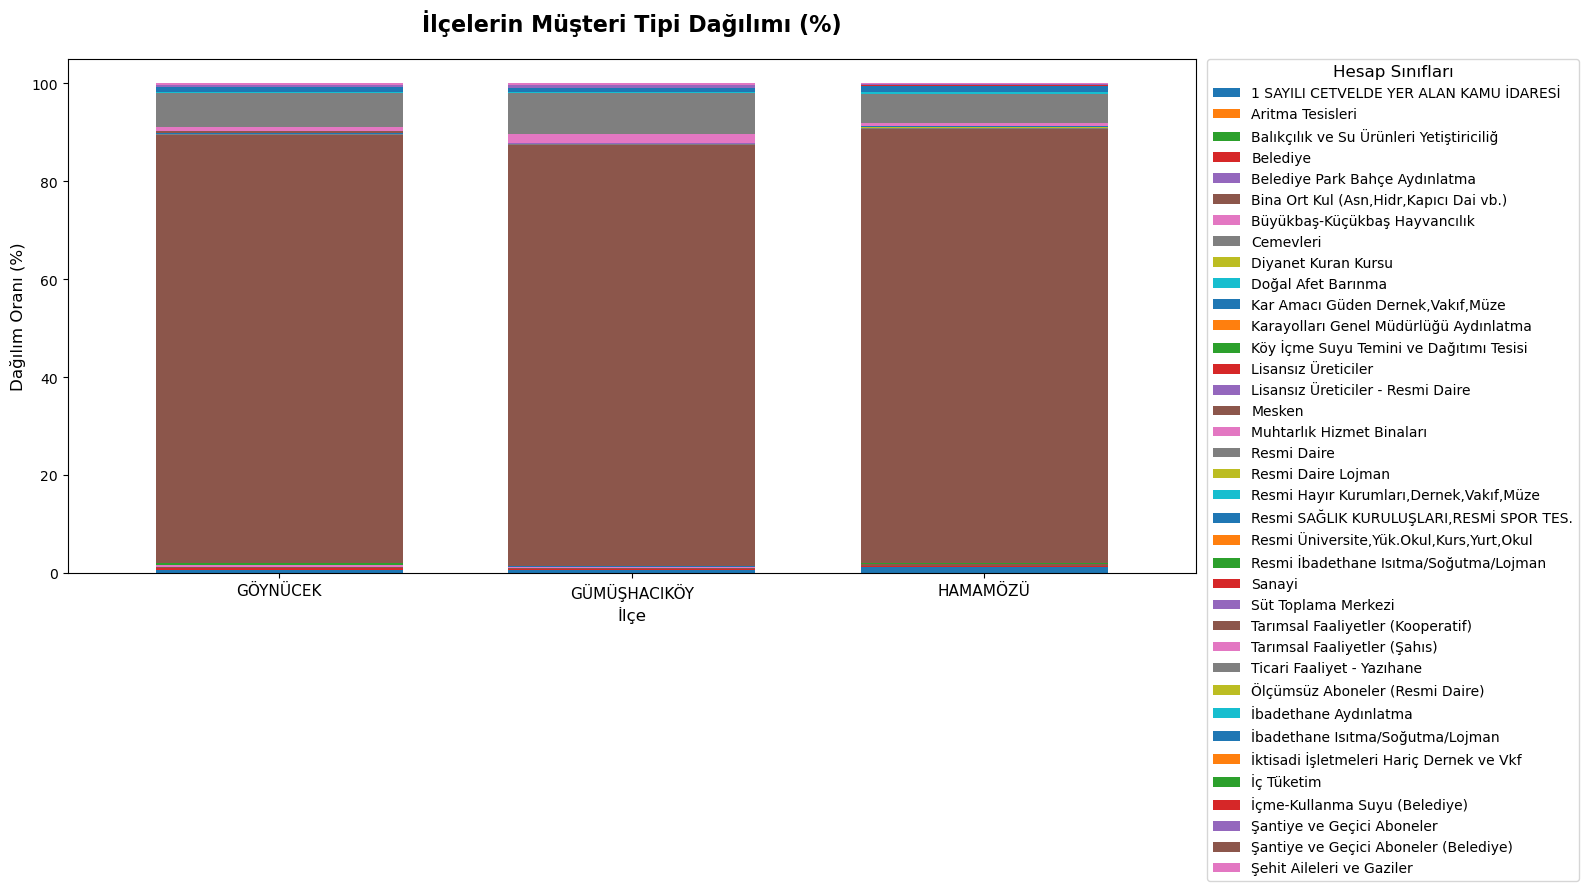

In [2]:
ilce_profil = pd.crosstab(df_tuketim['ilce'], df_tuketim['Hesap Sınıfı'], normalize='index') * 100

fig, ax = plt.subplots(figsize=(16, 8)) 
ilce_profil.plot(kind='bar', stacked=True, ax=ax, width=0.7)

plt.title("İlçelerin Müşteri Tipi Dağılımı (%)", fontsize=16, fontweight='bold', pad=20)
plt.ylabel("Dağılım Oranı (%)", fontsize=12)
plt.xlabel("İlçe", fontsize=12)
plt.xticks(rotation=0, fontsize=11)

plt.legend(title='Hesap Sınıfları', title_fontsize='12', bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()
plt.show()

**Bulgular:**

* **Gümüşhacıköy:** Ticari faaliyet ve Sanayi grubu payı diğer ilçelere göre yüksektir.Tüketim hacmini yukarı çeken ana faktör bu çeşitliliktir.
* **Hamamözü:**  Mesken oranı en yüksek ilçedir. Sanayi faliyetlerinin az olması, buradaki tüketimin öngörülebilir ve stabil olduğunu gösterir.
* **Göynücek:** Gümüşhacıköy kadar yoğun bir ticari yapı sergilememektedir. Muhtemelen Tarımsal ve Mesken yani karma bir yapıdadır.

**İş Önerileri:**

* **Hamamözü:** Standart hizmet bölgesi olarak belirlenip, buradaki hizmet faaliyetleri buna göre yapılmalıdır.
* **Gümüşhacıköy:** Arıza ve talep yoğunluğu yüksek olabilir, bu yüzden buraya teknik bir ekip verilebilir. Ayrıca buradaki olası enerji kesintilerinde haberleşme ağının dikkatli ve odaklı bir ekip olması önemlidir yoksa müşteri memnuniyetimiz düşebilir.


## 2. MÜŞTERİ SEGMENTASYONU

### Problem Tanımı
Tüm müşterilere aynı iletişim dilini kullanmak pazarlama bütçesini israf etmekte ve müşteri memnuniyetini düşürmektedir. Kimin "VIP" kimin "Standart" olduğu bilinmemektedir.

### Hipotezler
* **H1:** Müşterilerin %20'si, toplam tüketimin %80'ini gerçekleştirmektedir (Pareto).
* **H2:** Yüksek tüketimli müşteriler, enerji kesintilerine karşı daha hassastır ve özel ilgi bekler.

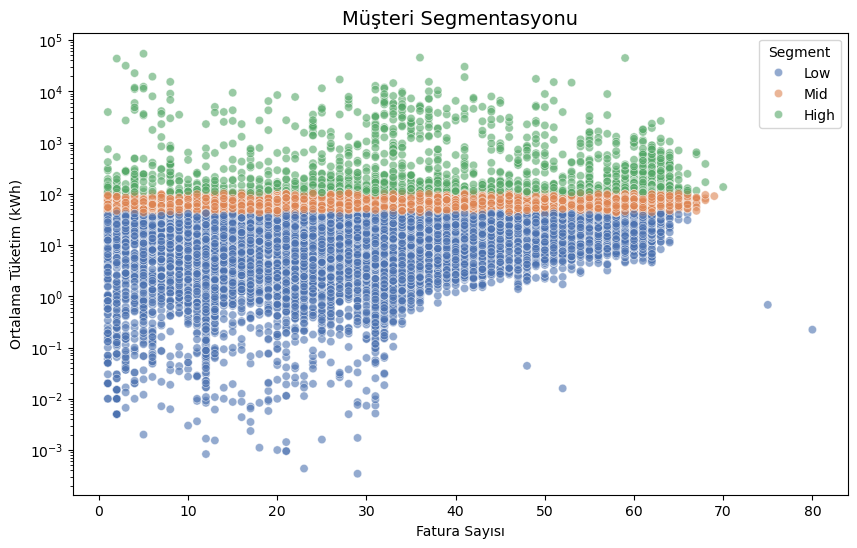

         Ort_Tuketim   Top_Tuketim
Segment                           
Low        17.402647    713.367087
Mid        67.653090   3376.708210
High      629.022154  21754.721958


/var/folders/40/gj75zf512wl3_p2dr2b8w2cm0000gn/T/ipykernel_14095/731963016.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(musteri_ozet.groupby('Segment')[['Ort_Tuketim', 'Top_Tuketim']].mean())


In [3]:
musteri_ozet = df_tuketim.groupby('sozlesme_hesap_no')['kwh'].agg(['mean', 'sum', 'count']).reset_index()
musteri_ozet.columns = ['Musteri_ID', 'Ort_Tuketim', 'Top_Tuketim', 'Fatura_Sayisi']

# Müşterileri tüketimlerine göre 3 sınıfa ayırabiliriz
# Düşük: %0-50, Orta: %50-90, Yüksek: %90-100
musteri_ozet['Segment'] = pd.qcut(musteri_ozet['Ort_Tuketim'], 
                                  q=[0, 0.5, 0.9, 1.0], 
                                  labels=['Low', 'Mid', 'High'])

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Fatura_Sayisi', y='Ort_Tuketim', hue='Segment', data=musteri_ozet, palette='deep', alpha=0.6)
plt.yscale('log')
plt.title("Müşteri Segmentasyonu", fontsize=14)
plt.ylabel("Ortalama Tüketim (kWh)")
plt.xlabel("Fatura Sayısı")
plt.show()

print(musteri_ozet.groupby('Segment')[['Ort_Tuketim', 'Top_Tuketim']].mean())

**Bulgular:**
* Ortalama tüketimdeki veriler, segmentler arasındaki farkı ortaya koymuştur:
    * **Low (Ekonomik):** Ort. **17.4 kWh**
    * **Mid (Standart):** Ort. **67.6 kWh**
    * **High (Yüksek):** Ort. **629.0 kWh**
* **Yüksek Segment:** Yüksek segmentindeki bir müşteri, standart bir müşteriden ortalama **9.3 kat**, düşük segmentteki bir müşteriden ise **36 kat** daha fazla enerji tüketmektedir. Şirket cirosunu ayakta tutan ana grup bu %10'luk kesimdir.
* **Şüpheli Düşük Tüketim:** Low segmentinin 17 kWh ortalaması bir buzdolabının aylık tüketiminden bile düşüktür. Bu durum bölgedeki yazlık veya boş ev yoğunluğunu veya olası kaçak elektrik kullanma durumlarını işaret eder.

**İş Önerileri:**
1. Ortalama 600 kWh üzeri tüketen yüksek segment grubu için standart çağrı merkezi yerine bu gruba özel bekleme süresi olmayan veya çok kısa olan bir iletişim hattı kurulabilir.
2. Low segmentindeki aboneler takip edilmelidir. Sayaç bozukluğu veya farklı bir durum olup olmadığı kontrol edilmelidir.
3. High segment müşterilere yönelik "Yüksek Tüketim İndirimi" veya "Sabit Fiyat Garantisi" sunularak, bu müşterilerin şirketimizde tutulması sağlanmalıdır.

## 3. TAHSİLAT PERFORMANS ANALİZİ

### Problem Tanımı
Şirketin nakit akışını bozan en büyük etken zamanında ödenmeyen faturalardır. Faturaların tiplerinin risk analizi yapılmalıdır.

### Hipotezler
* **H1:** Fatura tutarı arttıkça, nakit sıkışıklığı nedeniyle ödeme gecikme riski artmaktadır.
* **H2:** Belirli ödeme kanallarını kullanan müşteriler, otomatik ödeme kullananlara göre daha düzensiz ödeme yapmaktadır.

In [4]:
df_tahsilat_1.head()

,Mali yıl/dönem,İl,İlçe,Söz.hsp.(bağımsız),Hesap Sınıfı,Tahakkuk Tutar,Son Ödeme Tarihinden Önceki Tahsilat,Son Ödeme Tarihindeki Tahsilat,Son Ödeme (1),Son Ödeme (2),...,Son Ödeme (5),Son Ödeme (6-10),Son Ödeme (10-20),Son Ödeme (20-30),Son Ödeme (30-60),Son Ödeme (60-90),Son Ödeme (90-120),Son Ödeme (120-150),Son Ödeme (150-180),Son Ödeme (180+)
0,OCK 2023,AMASYA,GÖYNÜCEK,9374624783,Mesken,5.03,0.03,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN
1,OCK 2023,AMASYA,GÖYNÜCEK,236184905,Mesken,26.46,0.06,26.40,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,OCK 2023,AMASYA,GÖYNÜCEK,9657731015,Mesken,121.53,NaN,NaN,NaN,121.53,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,OCK 2023,AMASYA,GÖYNÜCEK,9554442880,Mesken,117.49,NaN,117.49,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,OCK 2023,AMASYA,GÖYNÜCEK,6031642522,Mesken,170.30,170.30,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


/var/folders/40/gj75zf512wl3_p2dr2b8w2cm0000gn/T/ipykernel_14095/1778988033.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Odeme_Profili', y='Tahakkuk Tutar', data=df_tahsilat_1, palette='Set1')


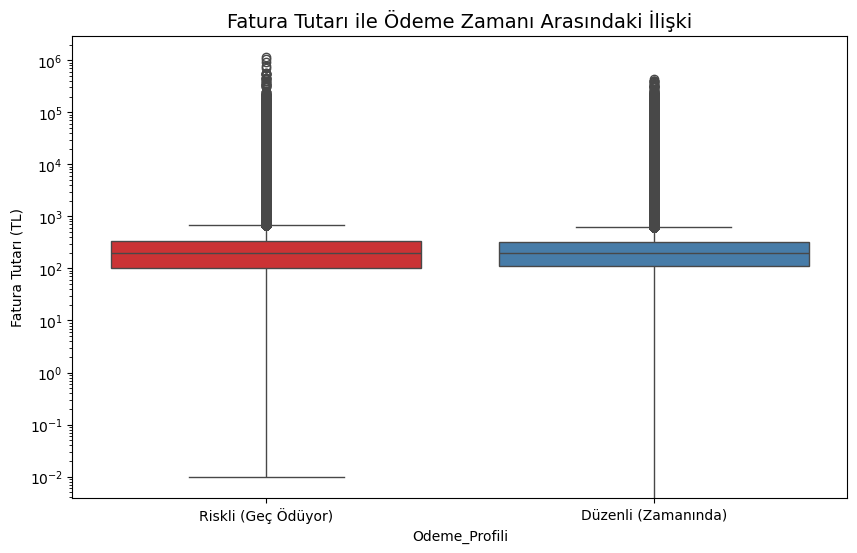

                        count        mean         max
Odeme_Profili                                        
Düzenli (Zamanında)  668178.0  456.745828   429056.57
Riskli (Geç Ödüyor)  249454.0  647.418733  1173258.44


In [5]:
gecikme_sutunlari = [col for col in df_tahsilat_1.columns if 'Son Ödeme (' in col]

df_tahsilat_1['Toplam_Gecikme'] = df_tahsilat_1[gecikme_sutunlari].sum(axis=1)

# Eğer gecikme tutarı > 0 ise "Riskli", değilse "Düzenli"
df_tahsilat_1['Odeme_Profili'] = df_tahsilat_1['Toplam_Gecikme'].apply(lambda x: 'Riskli (Geç Ödüyor)' if x > 0 else 'Düzenli (Zamanında)')

plt.figure(figsize=(10, 6))
sns.boxplot(x='Odeme_Profili', y='Tahakkuk Tutar', data=df_tahsilat_1, palette='Set1')
plt.yscale('log')
plt.title("Fatura Tutarı ile Ödeme Zamanı Arasındaki İlişki", fontsize=14)
plt.ylabel("Fatura Tutarı (TL)")
plt.show()

print(df_tahsilat_1.groupby('Odeme_Profili')['Tahakkuk Tutar'].describe()[['count', 'mean', 'max']])

**Bulgular:**
*  Veriler, ödeme zamanları ile fatura tutarı arasında doğrudan bir ilişki olduğunu kanıtlamıştır.
    * **Düzenli Ödeyenlerin** ortalama fatura tutarı: **456.7 TL**
    * **Geç Ödeyenlerin (Riskli)** ortalama fatura tutarı: **647.4 TL**
    * Riskli grubun ortalama faturası, düzenli gruba göre **%42 daha yüksektir.**
* **Riskli** kategorisindeki maksimum fatura tutarı **1.173.258 TL**'dir. Bu kadar büyük tutarlı tek bir faturanın bile gecikmesi ciroda dalgalanmalara yol açabilir. Düzenli gruptaki maksimum tutar ise 429.000 TL seviyesindedir.
* Toplam kayıtların yaklaşık %27'si (249.454 kayıt) "Riskli" kategorisine girmektedir.

**İş Önerileri:**
1.  * Büyük tutarlı faturalar için, abonelere son ödeme tarihinden 3 gün önce ve ödeme günü sabahında hatırlatma smsi veya otomatik arama yapılmalı.